# Tutorial on the LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset. 


- LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `llm` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models etc, see the [llmx documentation](https://github.com/victordibia/llmx)
- The summarizer module works takes an `enrich` argument which determines if the base summary is enriched by an LLM. By default, the `enrich` argument is set to `False`. 

## Installation

```bash 
pip install lida
```

Dont forget to setup your LLM API key. 

```bash
export OPENAI_API_KEY=<your key>
```



In [1]:
import json 
from lida import TextGenerationConfig , llm
from lida.components import Manager
from lida.utils import plot_raster 

## Summarize Data, Generate Goals

In [2]:
lida = Manager(text_gen = llm("openai")) # or llm("palm") etc
textgen_config = TextGenerationConfig(n=1, temperature=0.5, use_cache=True, max_tokens=1000)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", enrich=False, textgen_config=textgen_config) 
goals = lida.goals(summary, n=2, textgen_config=textgen_config)
print(goals)

/home/victordibia/projects/projectlida/lidarepo/lida/components/summarizer.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')
/home/victordibia/projects/projectlida/lidarepo/lida/components/summarizer.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')


[Goal(index=0, question='What is the distribution of Retail_Price?', visualization='histogram of Retail_Price', rationale='This tells about the range of prices of the cars in the dataset.'), Goal(index=1, question='What is the relationship between Weight and Horsepower_HP_?', visualization='scatter plot of Weight vs Horsepower_HP_', rationale='This helps to understand how the weight of the car affects its horsepower.')]


## Generate Visualizations

Code for generated chart: import matplotlib.pyplot as plt
import pandas as pd
# plan -
def plot(data: pd.DataFrame):
    # select the column to plot
    retail_price = data['Retail_Price']
    # plot the histogram
    plt.hist(retail_price, bins=30, color='green', alpha=0.8)
    # add vertical line for median
    median = retail_price.median()
    plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:0.2f}')
    # add legend
    plt.legend(loc='upper right')
    # set x and y labels
    plt.xlabel('Retail Price')
    plt.ylabel('Frequency')
    # set chart title
    plt.title('What is the distribution of Retail_Price?', wrap=True)
    return plt;

chart = plot(data)


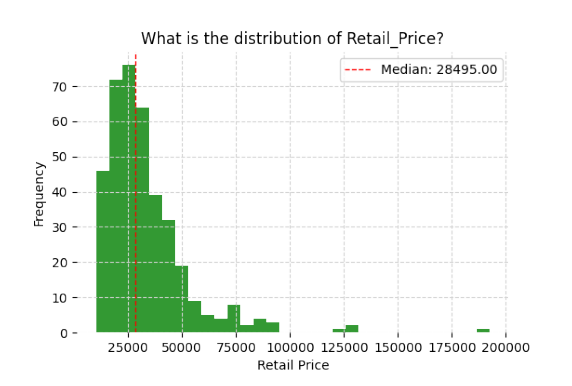

In [3]:
i = 0
library = "matplotlib"
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True, max_tokens=2000)
vis_specs = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library) 
charts = lida.execute(code_specs=vis_specs, data=lida.data, summary=summary, library=library )
print("Code for generated chart:", charts[0].code)

# plot raster image of chart
plot_raster(charts[0].raster) 

In [4]:
vis_specs

["import matplotlib.pyplot as plt\nimport pandas as pd\n# plan -\ndef plot(data: pd.DataFrame):\n    # select the column to plot\n    retail_price = data['Retail_Price']\n    # plot the histogram\n    plt.hist(retail_price, bins=30, color='green', alpha=0.8)\n    # add vertical line for median\n    median = retail_price.median()\n    plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:0.2f}')\n    # add legend\n    plt.legend(loc='upper right')\n    # set x and y labels\n    plt.xlabel('Retail Price')\n    plt.ylabel('Frequency')\n    # set chart title\n    plt.title('What is the distribution of Retail_Price?', wrap=True)\n    return plt;\n\nchart = plot(data) # data already contains the data to be plotted. Always include this line. DO NOT modify the rest of the code template."]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

In [5]:
code = charts[0].code
instructions = ["convert this to a scatterplot chart", "change the color to red"," ensure axis are legible"]
vis_specs = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)

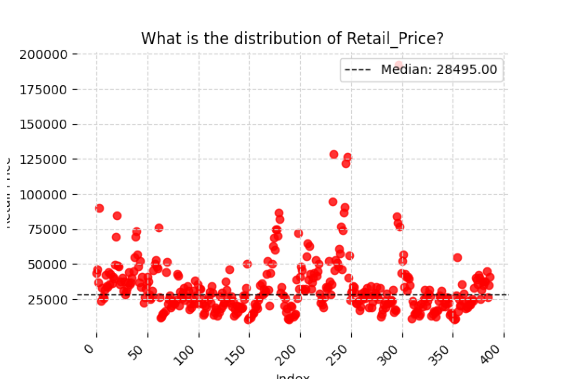

In [6]:
edited_charts = lida.execute(code_specs=vis_specs, data=lida.data, summary=summary, library=library) 
plot_raster(edited_charts[0].raster)

## Visualization explanations and accessibility

In [7]:
explanations = lida.explain(code=code,  library=library, textgen_config=textgen_config) 

In [8]:
print(explanations)

[[{'section': 'accessibility', 'code': 'None', 'explanation': "The goal of this chart is to visualize the distribution of the 'Retail_Price' column in the provided data. The chart is a histogram with 30 bins, where the x-axis represents the retail price and the y-axis represents the frequency of the retail price. The chart also includes a vertical line for the median value of the retail price, which is labeled with its value. The chart has a green color with an alpha of 0.8 for the histogram bars and a red dashed line for the median."}, {'section': 'transformation', 'code': 'None', 'explanation': "There is no data transformation in this code. The code only selects the 'Retail_Price' column from the provided data."}, {'section': 'visualization', 'code': "plt.hist(retail_price, bins=30, color='green', alpha=0.8)\nplt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:0.2f}')\nplt.legend(loc='upper right')\nplt.xlabel('Retail Price')\nplt.ylabel('Frequen

In [9]:
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The goal of this chart is to visualize the distribution of the 'Retail_Price' column in the provided data. The chart is a histogram with 30 bins, where the x-axis represents the retail price and the y-axis represents the frequency of the retail price. The chart also includes a vertical line for the median value of the retail price, which is labeled with its value. The chart has a green color with an alpha of 0.8 for the histogram bars and a red dashed line for the median.
transformation  **  There is no data transformation in this code. The code only selects the 'Retail_Price' column from the provided data.
visualization  **  The code first plots a histogram of the 'Retail_Price' column with 30 bins, a green color, and an alpha of 0.8. Then, it adds a vertical line for the median value of the retail price with a red dashed line, a linewidth of 1, and a label that includes the median value. The code then adds a legend to the chart in the upper right corner. Next, it s

## Visualization code self-evaluation and repair

In [10]:
evaluations = lida.evaluate(code=code,  goal=goals[i], library=library)
evaluations = json.loads(evaluations[0])

In [11]:
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])

bugs Score 10 / 10
	 The code does not contain any bugs, syntax errors, or typos. It should compile without any issues.
transformation Score 10 / 10
	 The data is appropriately filtered and no additional transformations are needed for the histogram.
compliance Score 10 / 10
	 The code meets the specified visualization goal of showing the distribution of Retail_Price.
type Score 9 / 10
	 The histogram is an appropriate visualization type for showing the distribution of a single variable. However, a box plot or violin plot could also be used to show the distribution and provide additio
encoding Score 10 / 10
	 The data is encoded appropriately for the histogram with Retail_Price on the x-axis and frequency on the y-axis.
aesthetics Score 9 / 10
	 The aesthetics of the histogram are appropriate with a green color and alpha of 0.8. However, the legend could be improved by specifying which line corresponds to the median and the title could be imp


## Visualization Recommendation

In [12]:
textgen_config = TextGenerationConfig(n=2, temperature=0.6, use_cache=True, max_tokens=None)
recommendations =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

In [13]:
recommendations

["import seaborn as sns\nimport pandas as pd\nimport matplotlib.pyplot as plt\n# solution plan\n# i.  ..\ndef plot(data: pd.DataFrame):\n\n    sns.boxplot(x='Type', y='Retail_Price', data=data)\n    plt.title('What is the distribution of Retail_Price by car type?', wrap=True)\n    return plt;",
 "import seaborn as sns\nimport pandas as pd\nimport matplotlib.pyplot as plt\n# solution plan\n# i.  ..\ndef plot(data: pd.DataFrame):\n\n    data['Retail_Price_Bin'] = pd.cut(data['Retail_Price'], bins=10)\n    sns.barplot(x='Retail_Price_Bin', y='Weight', data=data)\n    plt.xticks(rotation=45, ha='right')\n    plt.title('What is the average weight of cars by retail price bucket?', wrap=True)\n    return plt;"]

Recommended 2 charts
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# solution plan
# i.  ..
def plot(data: pd.DataFrame):

    sns.boxplot(x='Type', y='Retail_Price', data=data)
    plt.title('What is the distribution of Retail_Price by car type?', wrap=True)
    return plt;
chart = plot(data) 



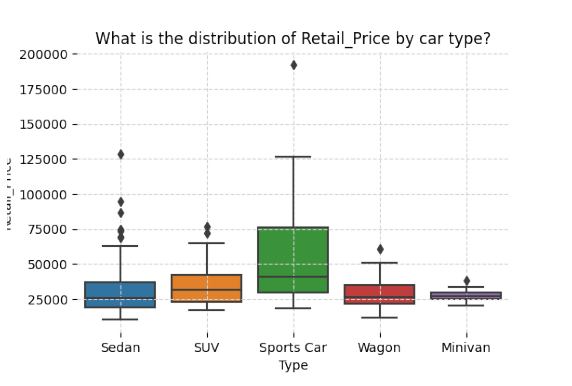

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# solution plan
# i.  ..
def plot(data: pd.DataFrame):

    data['Retail_Price_Bin'] = pd.cut(data['Retail_Price'], bins=10)
    sns.barplot(x='Retail_Price_Bin', y='Weight', data=data)
    plt.xticks(rotation=45, ha='right')
    plt.title('What is the average weight of cars by retail price bucket?', wrap=True)
    return plt;
chart = plot(data) 



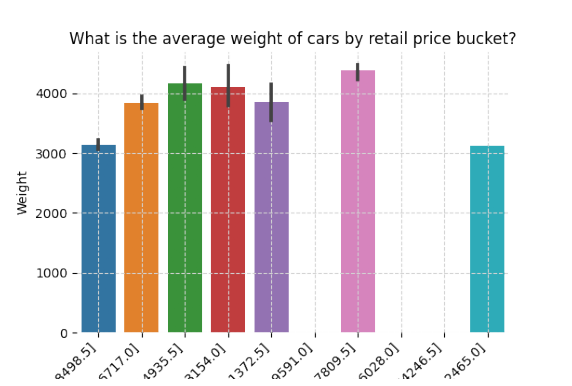

In [14]:

charts = lida.execute(code_specs=recommendations, data=lida.data, summary=summary, library=library)
print(f"Recommended {len(charts)} charts")
for chart in charts:
    print(chart.code, "\n====================\n")  
    # plot raster image of chart
    plot_raster(chart.raster) 
    pass

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models

In [21]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, sea shells")

Fetching 27 files: 100%|██████████| 27/27 [00:00<00:00, 130920.47it/s]
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Resizing init_image to (512, 512).
100%|██████████| 31/31 [00:01<00:00, 16.63it/s]


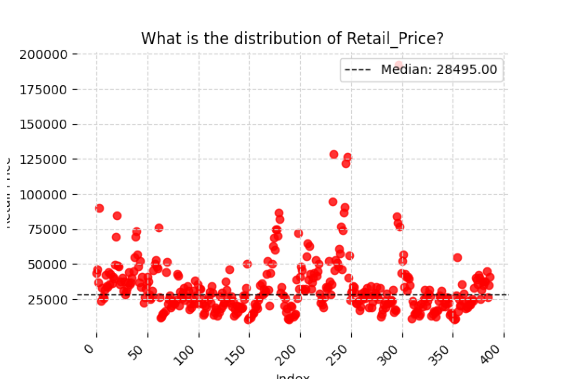

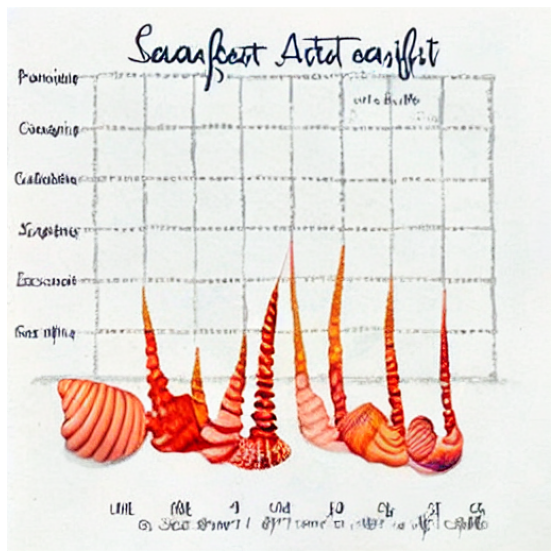

In [24]:
plot_raster(edited_charts[0].raster)
plot_raster(infographics["images"][0])